In [1]:
import optuna
import numpy as np  
import optuna.visualization as vis
import os
import plotly
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import seaborn as sns



/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



def Datos_reales(nombres,Normalizacion):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    all_signals=np.empty_like(Datos)
    for i, nombre in enumerate(nombres): 
        all_signals[i]=np.loadtxt(nombre)

    all_values = np.concatenate(all_signals)  # Combinar todos los datos
    global_max = np.max(all_values)
    global_max_abs = np.max(abs(all_values))
    global_mean = np.mean(all_values)
    global_std = np.std(all_values)

    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 
        data = np.loadtxt(nombre)

        if(Normalizacion=="max_global"):    
            data=data / global_max
        elif(Normalizacion=="max_global_abs"):
            data=data /global_max_abs
        elif(Normalizacion=="zscore"):
            data=(data -global_mean) / global_std

        Datos[i]=data
        Butter[i]=butter= signal.filtfilt(b, a,data)

        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [3]:
number_top=150

In [4]:
# Directorio donde están almacenados los estudios
study_directory = "Estudios/Full_Trest_p"  # Asegúrate de que este sea el directorio correcto

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)




# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos
best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:15]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Values:", trial.values)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")


Global Trial 1:
Study: Chi30_zscore
Params: {'L': 58, 'P': 0.0007589733440927518, 'Inh': 0.5438777844425376, 'Trest': 0.3505494669881555, 'Trelative': 0.6109066904215035, 'C_h': 0.8343814876883018, 'Tipo_red': 1}
Values: [31.179327202602085]
Sum of Values: 31.179327202602085
---------------------------------------
Global Trial 2:
Study: Chi30_zscore
Params: {'L': 57, 'P': 0.0005983668855232827, 'Inh': 0.5401663859851108, 'Trest': 0.4870677199089034, 'Trelative': 0.7249517641458323, 'C_h': 0.8197413784903088, 'Tipo_red': 1}
Values: [35.51650421499946]
Sum of Values: 35.51650421499946
---------------------------------------
Global Trial 3:
Study: Chi30_zscore
Params: {'L': 58, 'P': 0.00027688307009486775, 'Inh': 0.5143921451867285, 'Trest': 0.30013080920588486, 'Trelative': 0.4420508660162553, 'C_h': 0.8849273607473115, 'Tipo_red': 1}
Values: [36.42256035215466]
Sum of Values: 36.42256035215466
---------------------------------------
Global Trial 4:
Study: Chi30_zscore
Params: {'L': 55, 


Frecuencia de aparición de cada estudio en los mejores 150 ensayos:
Estudio Chi30_zscore: 126 veces
Estudio Chi30_max_global: 24 veces

Frecuencia de cada tipo de red en los mejores 150 ensayos:
Tipo de red 1: 123 veces
Tipo de red 4: 24 veces
Tipo de red 0: 2 veces
Tipo de red 3: 1 veces

Media del tamaño L en los mejores 150 ensayos: 49.76


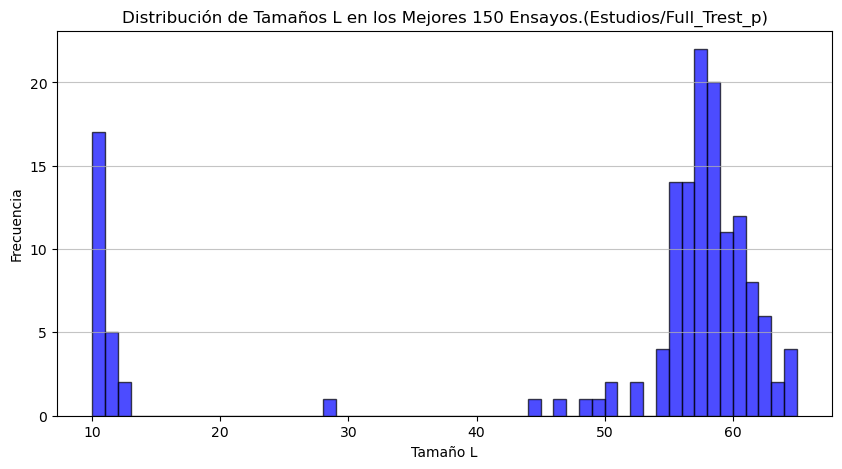

In [5]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L

# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)
size_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
     network_type_frequency_count[network_type] += 1

for size in sizes:
    size_frequency_count[size] += 1  # Contar la frecuencia de cada tamaño L

print(f"\nFrecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"\nFrecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")

mean_size = np.mean(sizes)
print(f"\nMedia del tamaño L en los mejores {number_top} ensayos: {mean_size}")

# Graficar la distribución de los tamaños L
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=range(min(sizes), max(sizes) + 1), alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Distribución de Tamaños L en los Mejores {number_top} Ensayos.({study_directory})')
plt.xlabel('Tamaño L')
plt.ylabel('Frecuencia')
#plt.xticks(range(min(sizes), max(sizes) + 1,3))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [6]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L
trest_values = [trial.params['Trest'] for trial in best_trials_global]  # Recopilar Trest
trela_values = [trial.params['Trelative'] for trial in best_trials_global]  # Recopilar Trest
Chiper=[trial.params['C_h'] for trial in best_trials_global]  # Recopilar Trest

P_values = [trial.params['P'] for trial in best_trials_global]  # Recopilar P
Inh_values = [trial.params['Inh'] for trial in best_trials_global]  # Recopilar P
# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1
print(f"\nMedia del L: {np.mean(sizes)}")
print(f"Desviación estándar del L: {np.std(sizes)}")
print(f"Mediana del L: { np.median(sizes)}")
print(f"Primer cuartil (Q1) del L: {np.percentile(sizes, 25)}")
print(f"Tercer cuartil (Q3) del L: {np.percentile(sizes, 75)}")


print(f"\nMedia del Trest: {np.mean(trest_values)}")
print(f"Desviación estándar del Trest: {np.std(trest_values)}")
print(f"Mediana del Trest: {np.median(trest_values)}")
print(f"Primer cuartil (Q1) del Trest: {np.percentile(trest_values, 25)}")
print(f"Tercer cuartil (Q3) del Trest: {np.percentile(trest_values, 75)}")

print(f"\nMedia del Trela: {np.mean(trela_values)}")
print(f"Desviación estándar del Trela: {np.std(trela_values)}")
print(f"Mediana del Trela: {np.median(trela_values)}")
print(f"Primer cuartil (Q1) del Trela: {np.percentile(trela_values, 25)}")
print(f"Tercer cuartil (Q3) del Trela: {np.percentile(trela_values, 75)}")

print(f"\nMedia del P: {np.mean(P_values)}")
print(f"Desviación estándar del P: {np.std(P_values)}")
print(f"Mediana del P: { np.median(P_values)}")
print(f"Primer cuartil (Q1) del P: {np.percentile(P_values, 25)}")
print(f"Tercer cuartil (Q3) del P: {np.percentile(P_values, 75)}")

print(f"\nMedia del Inh: {np.mean(Inh_values)}")
print(f"Desviación estándar del Inh: {np.std(Inh_values)}")
print(f"Mediana del Inh: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del Inh: {np.percentile(Inh_values, 25)}")
print(f"Tercer cuartil (Q3) del Inh: {np.percentile(Inh_values, 75)}")

print(f"\nMedia del C hiper: {np.mean(Chiper)}")
print(f"Desviación estándar del C hiper: {np.std(Chiper)}")
print(f"Mediana del C hiper: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del C hiper: {np.percentile(Chiper, 25)}")
print(f"Tercer cuartil (Q3) del C hiperh: {np.percentile(Chiper, 75)}")


Media del L: 49.76
Desviación estándar del L: 17.622591561212936
Mediana del L: 57.0
Primer cuartil (Q1) del L: 55.0
Tercer cuartil (Q3) del L: 59.0

Media del Trest: 0.4234034767008415
Desviación estándar del Trest: 0.24965356127393978
Mediana del Trest: 0.3689131066536929
Primer cuartil (Q1) del Trest: 0.24255450356923397
Tercer cuartil (Q3) del Trest: 0.5365320065288013

Media del Trela: 0.9102737173231688
Desviación estándar del Trela: 1.0403125837356222
Mediana del Trela: 0.6266156408995462
Primer cuartil (Q1) del Trela: 0.4799874660024366
Tercer cuartil (Q3) del Trela: 0.9221760280225708

Media del P: 0.04269679421284195
Desviación estándar del P: 0.07030043230726113
Mediana del P: 0.019710199401892052
Primer cuartil (Q1) del P: 0.0023127203847822407
Tercer cuartil (Q3) del P: 0.049236084807505444

Media del Inh: 0.5499563767837606
Desviación estándar del Inh: 0.08075242889875209
Mediana del Inh: 0.5256066201489901
Primer cuartil (Q1) del Inh: 0.5044395841604428
Tercer cuartil (

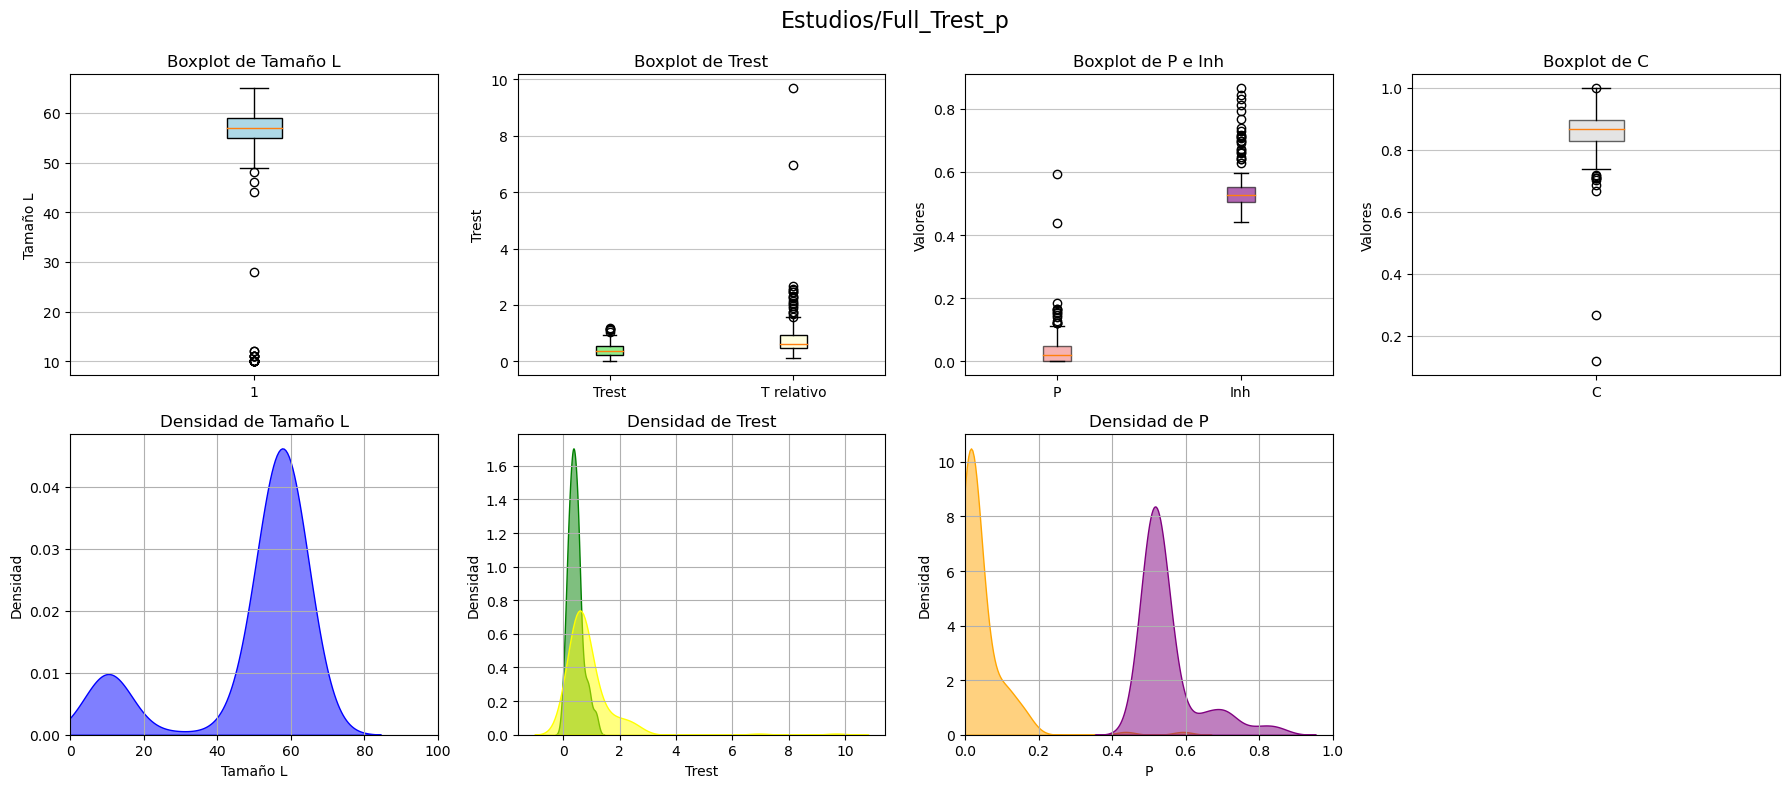

In [7]:
plt.figure(figsize=(18, 8))

# Boxplot de Tamaño L
plt.subplot(2, 4, 1)
plt.boxplot(sizes, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Tamaño L')
plt.ylabel('Tamaño L')
plt.grid(axis='y', alpha=0.75)

# Boxplot de Trest
plt.subplot(2, 4, 2)
plt.boxplot(trest_values, patch_artist=True, boxprops=dict(facecolor='lightgreen'),labels=["Trest"])
plt.boxplot(trela_values, patch_artist=True, boxprops=dict(facecolor='lightyellow'),positions=[2],labels=['T relativo'])
plt.title('Boxplot de Trest')
plt.ylabel('Trest')
plt.grid(axis='y', alpha=0.75)

# Boxplot de P
plt.subplot(2, 4, 3)
plt.boxplot(P_values, patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.6), labels=['P'])  # Asignar etiqueta para P
plt.boxplot(Inh_values, patch_artist=True, boxprops=dict(facecolor='purple', alpha=0.6), positions=[2])  # Asignar etiqueta para Inh, en posición 2
plt.title('Boxplot de P e Inh')
plt.ylabel('Valores')
plt.xticks([1, 2], ['P', 'Inh'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 4, 4)
plt.boxplot(Chiper, patch_artist=True, boxprops=dict(facecolor='lightgrey', alpha=0.6), labels=['C'])  # Asignar etiqueta para P
plt.title('Boxplot de C')
plt.ylabel('Valores')
plt.xticks([1], ['C'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)


plt.subplot(2, 4, 5)
sns.kdeplot(sizes, fill=True, color='blue', alpha=0.5)
plt.title('Densidad de Tamaño L')
plt.xlabel('Tamaño L')
plt.xlim(0,100)
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para Trest
plt.subplot(2, 4, 6)
sns.kdeplot(trest_values, fill=True, color='green', alpha=0.5)
sns.kdeplot(trela_values, fill=True, color='yellow', alpha=0.5)
plt.title('Densidad de Trest')
plt.xlabel('Trest')
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para P
plt.subplot(2, 4, 7)
sns.kdeplot(P_values, fill=True, color='orange', alpha=0.5)
sns.kdeplot(Inh_values, fill=True, color='purple', alpha=0.5)
plt.title('Densidad de P')
plt.xlabel('P')
plt.xlim(0,1)
plt.ylabel('Densidad')
plt.grid()

plt.tight_layout()
plt.suptitle(study_directory, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Ajustar para evitar superposición con el título
plt.show()


In [8]:
# Directorio donde están almacenados los estudios
study_directory = "Estudios/Full"  # Asegúrate de que este sea el directorio correcto

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)




# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos
best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:15]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Values:", trial.values)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")


Global Trial 1:
Study: Chi30_max_global
Params: {'L': 15, 'P': 0.3780703389644099, 'Inh': 0.6358066855917539, 'Trest': -4.739855306871973, 'Trelative': -0.5845066272055987, 'C_h': 0.984180380236879, 'Tipo_red': 2}
Values: [28.55896175271282]
Sum of Values: 28.55896175271282
---------------------------------------
Global Trial 2:
Study: Chi30_max_global
Params: {'L': 14, 'P': 0.35320939805124685, 'Inh': 0.631079741058146, 'Trest': -4.753345676538505, 'Trelative': -0.7739143978467913, 'C_h': 0.9289904073770494, 'Tipo_red': 2}
Values: [32.04563278757441]
Sum of Values: 32.04563278757441
---------------------------------------
Global Trial 3:
Study: Chi30_max_global
Params: {'L': 13, 'P': 0.38299928179040205, 'Inh': 0.6281692424342519, 'Trest': -3.9840651007262857, 'Trelative': -0.5301642104058547, 'C_h': 0.9992869305670347, 'Tipo_red': 2}
Values: [32.27338242776495]
Sum of Values: 32.27338242776495
---------------------------------------
Global Trial 4:
Study: Chi30_max_global
Params: {'L


Frecuencia de aparición de cada estudio en los mejores 150 ensayos:
Estudio Chi30_max_global: 114 veces
Estudio Chi30_zscore: 36 veces

Frecuencia de cada tipo de red en los mejores 150 ensayos:
Tipo de red 2: 109 veces
Tipo de red 4: 35 veces
Tipo de red 1: 3 veces
Tipo de red 0: 3 veces

Media del tamaño L en los mejores 150 ensayos: 21.713333333333335


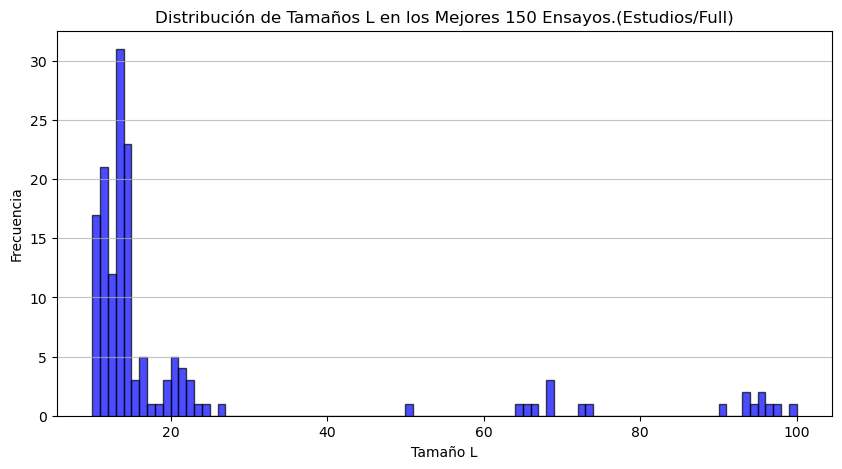

In [9]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L

# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)
size_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1

for size in sizes:
    size_frequency_count[size] += 1  # Contar la frecuencia de cada tamaño L

print(f"\nFrecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"\nFrecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")

mean_size = np.mean(sizes)
print(f"\nMedia del tamaño L en los mejores {number_top} ensayos: {mean_size}")

# Graficar la distribución de los tamaños L
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=range(min(sizes), max(sizes) + 1), alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Distribución de Tamaños L en los Mejores {number_top} Ensayos.({study_directory})')
plt.xlabel('Tamaño L')
plt.ylabel('Frecuencia')
#plt.xticks(range(min(sizes), max(sizes) + 1,3))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [10]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L
trest_values = [trial.params['Trest'] for trial in best_trials_global]  # Recopilar Trest
trela_values = [trial.params['Trelative'] for trial in best_trials_global]  # Recopilar Trest
Chiper=[trial.params['C_h'] for trial in best_trials_global]  # Recopilar Trest

P_values = [trial.params['P'] for trial in best_trials_global]  # Recopilar P
Inh_values = [trial.params['Inh'] for trial in best_trials_global]  # Recopilar P
# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1


# Mostrar la frecuencia de aparición de cada estudio en los mejores 150 ensayos
print(f"\nFrecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"\nFrecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")




Frecuencia de aparición de cada estudio en los mejores 150 ensayos:
Estudio Chi30_max_global: 114 veces
Estudio Chi30_zscore: 36 veces

Frecuencia de cada tipo de red en los mejores 150 ensayos:
Tipo de red 2: 109 veces
Tipo de red 4: 35 veces
Tipo de red 1: 3 veces
Tipo de red 0: 3 veces


In [11]:
print(f"\nMedia del L: {np.mean(sizes)}")
print(f"Desviación estándar del L: {np.std(sizes)}")
print(f"Mediana del L: { np.median(sizes)}")
print(f"Primer cuartil (Q1) del L: {np.percentile(sizes, 25)}")
print(f"Tercer cuartil (Q3) del L: {np.percentile(sizes, 75)}")


print(f"\nMedia del Trest: {np.mean(trest_values)}")
print(f"Desviación estándar del Trest: {np.std(trest_values)}")
print(f"Mediana del Trest: {np.median(trest_values)}")
print(f"Primer cuartil (Q1) del Trest: {np.percentile(trest_values, 25)}")
print(f"Tercer cuartil (Q3) del Trest: {np.percentile(trest_values, 75)}")

print(f"\nMedia del Trela: {np.mean(trela_values)}")
print(f"Desviación estándar del Trela: {np.std(trela_values)}")
print(f"Mediana del Trela: {np.median(trela_values)}")
print(f"Primer cuartil (Q1) del Trela: {np.percentile(trela_values, 25)}")
print(f"Tercer cuartil (Q3) del Trela: {np.percentile(trela_values, 75)}")

print(f"\nMedia del P: {np.mean(P_values)}")
print(f"Desviación estándar del P: {np.std(P_values)}")
print(f"Mediana del P: { np.median(P_values)}")
print(f"Primer cuartil (Q1) del P: {np.percentile(P_values, 25)}")
print(f"Tercer cuartil (Q3) del P: {np.percentile(P_values, 75)}")

print(f"\nMedia del Inh: {np.mean(Inh_values)}")
print(f"Desviación estándar del Inh: {np.std(Inh_values)}")
print(f"Mediana del Inh: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del Inh: {np.percentile(Inh_values, 25)}")
print(f"Tercer cuartil (Q3) del Inh: {np.percentile(Inh_values, 75)}")

print(f"\nMedia del C hiper: {np.mean(Chiper)}")
print(f"Desviación estándar del C hiper: {np.std(Chiper)}")
print(f"Mediana del C hiper: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del C hiper: {np.percentile(Chiper, 25)}")
print(f"Tercer cuartil (Q3) del C hiperh: {np.percentile(Chiper, 75)}")


Media del L: 21.713333333333335
Desviación estándar del L: 22.526232609017324
Mediana del L: 13.0
Primer cuartil (Q1) del L: 11.25
Tercer cuartil (Q3) del L: 16.75

Media del Trest: -3.88453978973511
Desviación estándar del Trest: 2.7130613036433515
Mediana del Trest: -4.73006305018803
Primer cuartil (Q1) del Trest: -5.712414631969107
Tercer cuartil (Q3) del Trest: -3.194939565764854

Media del Trela: -0.3517602786175178
Desviación estándar del Trela: 1.4109945448112633
Mediana del Trela: -0.4312920277458312
Primer cuartil (Q1) del Trela: -0.8035950615459414
Tercer cuartil (Q3) del Trela: -0.018346031058490836

Media del P: 0.4217251938345459
Desviación estándar del P: 0.29160664249666296
Mediana del P: 0.3904766154548682
Primer cuartil (Q1) del P: 0.19296038999488652
Tercer cuartil (Q3) del P: 0.6012586446744592

Media del Inh: 0.5217741884056045
Desviación estándar del Inh: 0.08721481121511665
Mediana del Inh: 0.49315146557129896
Primer cuartil (Q1) del Inh: 0.4453647528648411
Terce

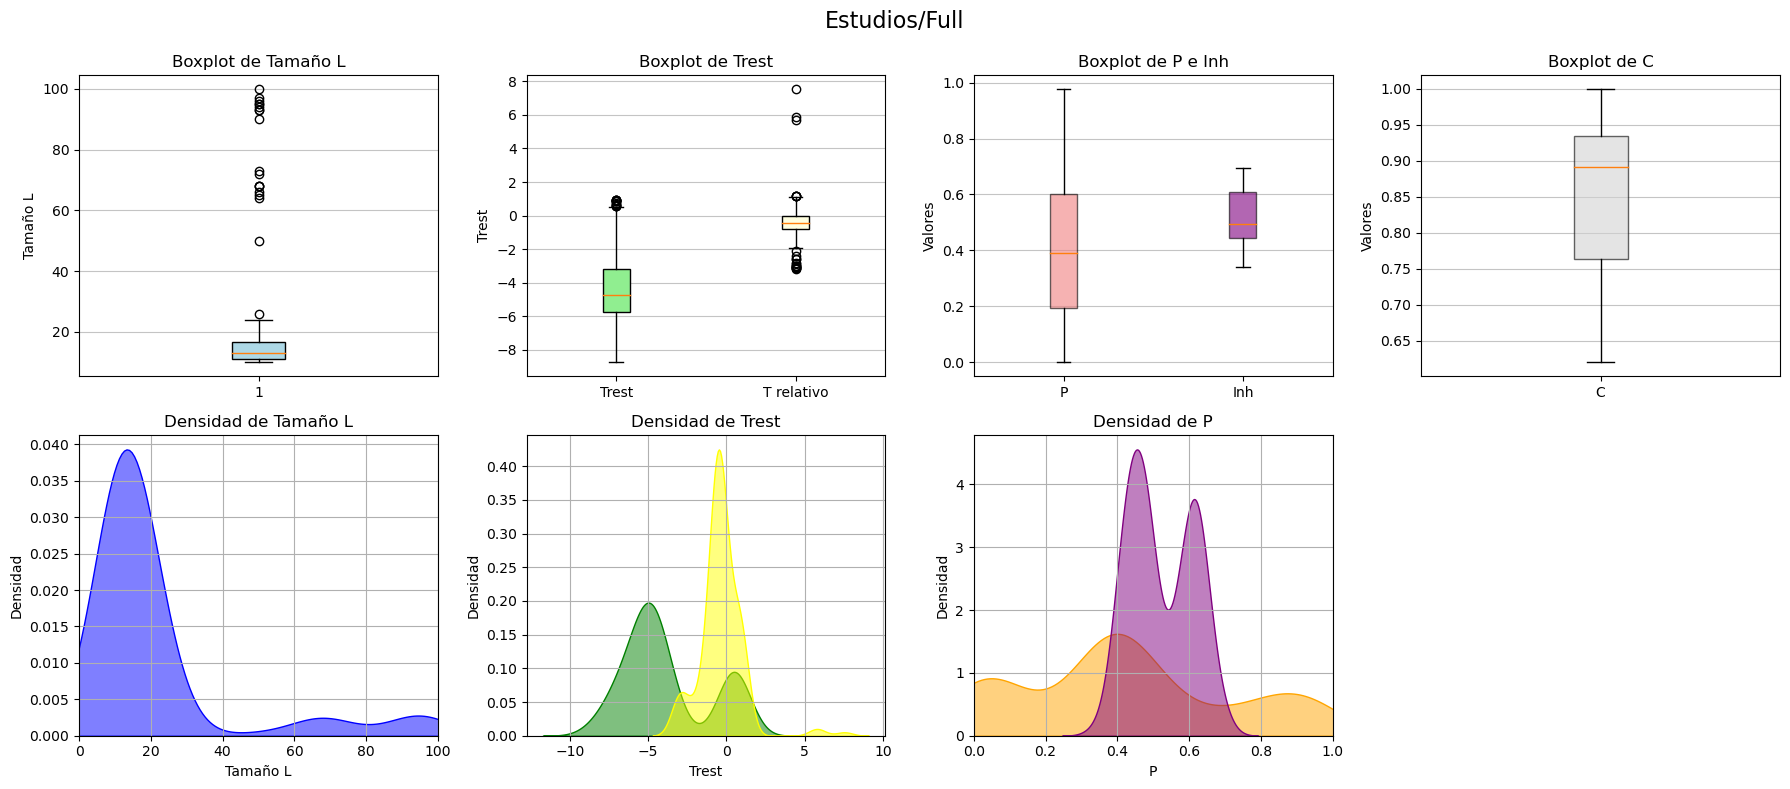

In [12]:
plt.figure(figsize=(18, 8))

# Boxplot de Tamaño L
plt.subplot(2, 4, 1)
plt.boxplot(sizes, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Tamaño L')
plt.ylabel('Tamaño L')
plt.grid(axis='y', alpha=0.75)

# Boxplot de Trest
plt.subplot(2, 4, 2)
plt.boxplot(trest_values, patch_artist=True, boxprops=dict(facecolor='lightgreen'),labels=["Trest"])
plt.boxplot(trela_values, patch_artist=True, boxprops=dict(facecolor='lightyellow'),positions=[2],labels=['T relativo'])
plt.title('Boxplot de Trest')
plt.ylabel('Trest')
plt.grid(axis='y', alpha=0.75)

# Boxplot de P
plt.subplot(2, 4, 3)
plt.boxplot(P_values, patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.6), labels=['P'])  # Asignar etiqueta para P
plt.boxplot(Inh_values, patch_artist=True, boxprops=dict(facecolor='purple', alpha=0.6), positions=[2])  # Asignar etiqueta para Inh, en posición 2
plt.title('Boxplot de P e Inh')
plt.ylabel('Valores')
plt.xticks([1, 2], ['P', 'Inh'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 4, 4)
plt.boxplot(Chiper, patch_artist=True, boxprops=dict(facecolor='lightgrey', alpha=0.6), labels=['C'])  # Asignar etiqueta para P
plt.title('Boxplot de C')
plt.ylabel('Valores')
plt.xticks([1], ['C'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)


plt.subplot(2, 4, 5)
sns.kdeplot(sizes, fill=True, color='blue', alpha=0.5)
plt.title('Densidad de Tamaño L')
plt.xlabel('Tamaño L')
plt.xlim(0,100)
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para Trest
plt.subplot(2, 4, 6)
sns.kdeplot(trest_values, fill=True, color='green', alpha=0.5)
sns.kdeplot(trela_values, fill=True, color='yellow', alpha=0.5)
plt.title('Densidad de Trest')
plt.xlabel('Trest')
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para P
plt.subplot(2, 4, 7)
sns.kdeplot(P_values, fill=True, color='orange', alpha=0.5)
sns.kdeplot(Inh_values, fill=True, color='purple', alpha=0.5)
plt.title('Densidad de P')
plt.xlabel('P')
plt.xlim(0,1)
plt.ylabel('Densidad')
plt.grid()

plt.suptitle(study_directory, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99]) 
plt.show()


In [13]:
# Directorio donde están almacenados los estudios
study_directory = "Estudios/Small_world"  # Asegúrate de que este sea el directorio correcto

# Ruta completa para la base de datos (asume que todas están en formato SQLite)
storage_prefix = "sqlite:///"

# Lista para almacenar los mejores ensayos de todos los estudios
all_trials_global = []

# Listar todos los archivos en el directorio de estudios que tengan la extensión .db
for file_name in os.listdir(study_directory):
    if file_name.endswith(".db"):  # Filtrar solo los archivos .db
        study_name = file_name.replace(".db", "")  # Obtener el nombre del estudio sin la extensión .db
        
        # Cargar el estudio
        study = optuna.load_study(study_name=study_name, storage=storage_prefix + os.path.join(study_directory, file_name))
        
        # Filtrar los ensayos válidos
        valid_trials = [t for t in study.trials if t.values is not None]
        
        # Agregar los ensayos válidos a la lista global
        for trial in valid_trials:
            trial.study_name = study_name  # Asignar el nombre del estudio al ensayo
            all_trials_global.append(trial)




# Ordenar todos los ensayos válidos de todos los estudios por la suma de los valores de los objetivos
best_trials_global = sorted(all_trials_global, key=lambda t: sum(t.values))[:number_top]  # Tomar los mejores 150

for i, trial in enumerate(best_trials_global[:15]):
    print(f"Global Trial {i + 1}:")
    print("Study:", trial.study_name)
    print("Params:", trial.params)
    print("Values:", trial.values)
    print("Sum of Values:", sum(trial.values))
    print("---------------------------------------")


Global Trial 1:
Study: Chi30_max_global
Params: {'L': 12, 'P': 0.29421208241452945, 'Inh': 0.606963959055267, 'Trest': -6.381187102341862, 'Trelative': -0.5584276467355, 'C_h': 0.978404616571725, 'Tipo_red': 2}
Values: [19.755146792815943]
Sum of Values: 19.755146792815943
---------------------------------------
Global Trial 2:
Study: Chi30_max_global
Params: {'L': 13, 'P': 0.16425151050264386, 'Inh': 0.609564448795891, 'Trest': -7.455973676187662, 'Trelative': -0.34020823235336334, 'C_h': 0.9267626547995091, 'Tipo_red': 2}
Values: [25.34114506659034]
Sum of Values: 25.34114506659034
---------------------------------------
Global Trial 3:
Study: Chi30_max_global
Params: {'L': 12, 'P': 0.10507324771088963, 'Inh': 0.5638550895062164, 'Trest': -7.224350735713429, 'Trelative': -0.12939468266271625, 'C_h': 0.9371939900783725, 'Tipo_red': 2}
Values: [25.94475801873142]
Sum of Values: 25.94475801873142
---------------------------------------
Global Trial 4:
Study: Chi30_max_global
Params: {'L


Frecuencia de aparición de cada estudio en los mejores 150 ensayos:
Estudio Chi30_max_global: 150 veces

Frecuencia de cada tipo de red en los mejores 150 ensayos:
Tipo de red 2: 123 veces
Tipo de red 1: 27 veces

Media del tamaño L en los mejores 150 ensayos: 12.02


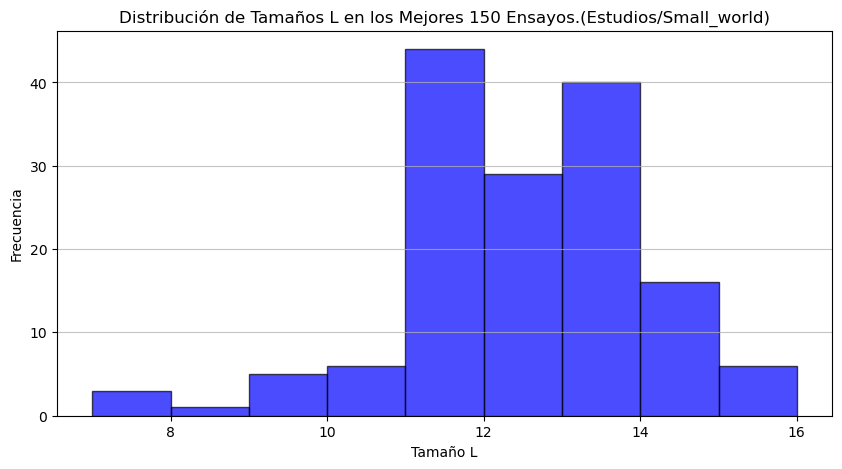

In [14]:
study_names = [trial.study_name for trial in best_trials_global]
network_types = [trial.params['Tipo_red'] for trial in best_trials_global]
sizes = [trial.params['L'] for trial in best_trials_global]  # Recopilar tamaños L

# Contar las frecuencias
study_frequency_count = defaultdict(int)
network_type_frequency_count = defaultdict(int)
size_frequency_count = defaultdict(int)

for study in study_names:
    study_frequency_count[study] += 1

for network_type in network_types:
    network_type_frequency_count[network_type] += 1

for size in sizes:
    size_frequency_count[size] += 1  # Contar la frecuencia de cada tamaño L

print(f"\nFrecuencia de aparición de cada estudio en los mejores {number_top} ensayos:")
for study_name, count in study_frequency_count.items():
    print(f"Estudio {study_name}: {count} veces")

# Mostrar la frecuencia de cada tipo de red en los mejores 150 ensayos
print(f"\nFrecuencia de cada tipo de red en los mejores {number_top} ensayos:")
for network_type, count in network_type_frequency_count.items():
    print(f"Tipo de red {network_type}: {count} veces")

mean_size = np.mean(sizes)
print(f"\nMedia del tamaño L en los mejores {number_top} ensayos: {mean_size}")

# Graficar la distribución de los tamaños L
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=range(min(sizes), max(sizes) + 1), alpha=0.7, color='blue', edgecolor='black')
plt.title(f'Distribución de Tamaños L en los Mejores {number_top} Ensayos.({study_directory})')
plt.xlabel('Tamaño L')
plt.ylabel('Frecuencia')
#plt.xticks(range(min(sizes), max(sizes) + 1,3))
plt.grid(axis='y', alpha=0.75)
plt.show()


Media del L: 12.02
Desviación estándar del L: 1.5977901405795858
Mediana del L: 12.0
Primer cuartil (Q1) del L: 11.0
Tercer cuartil (Q3) del L: 13.0

Media del Trest: -3.88453978973511
Desviación estándar del Trest: 2.7130613036433515
Mediana del Trest: -4.73006305018803
Primer cuartil (Q1) del Trest: -5.712414631969107
Tercer cuartil (Q3) del Trest: -3.194939565764854

Media del Trela: -0.3517602786175178
Desviación estándar del Trela: 1.4109945448112633
Mediana del Trela: -0.4312920277458312
Primer cuartil (Q1) del Trela: -0.8035950615459414
Tercer cuartil (Q3) del Trela: -0.018346031058490836

Media del P: 0.4217251938345459
Desviación estándar del P: 0.29160664249666296
Mediana del P: 0.3904766154548682
Primer cuartil (Q1) del P: 0.19296038999488652
Tercer cuartil (Q3) del P: 0.6012586446744592

Media del Inh: 0.5217741884056045
Desviación estándar del Inh: 0.08721481121511665
Mediana del Inh: 0.49315146557129896
Primer cuartil (Q1) del Inh: 0.4453647528648411
Tercer cuartil (Q3) 

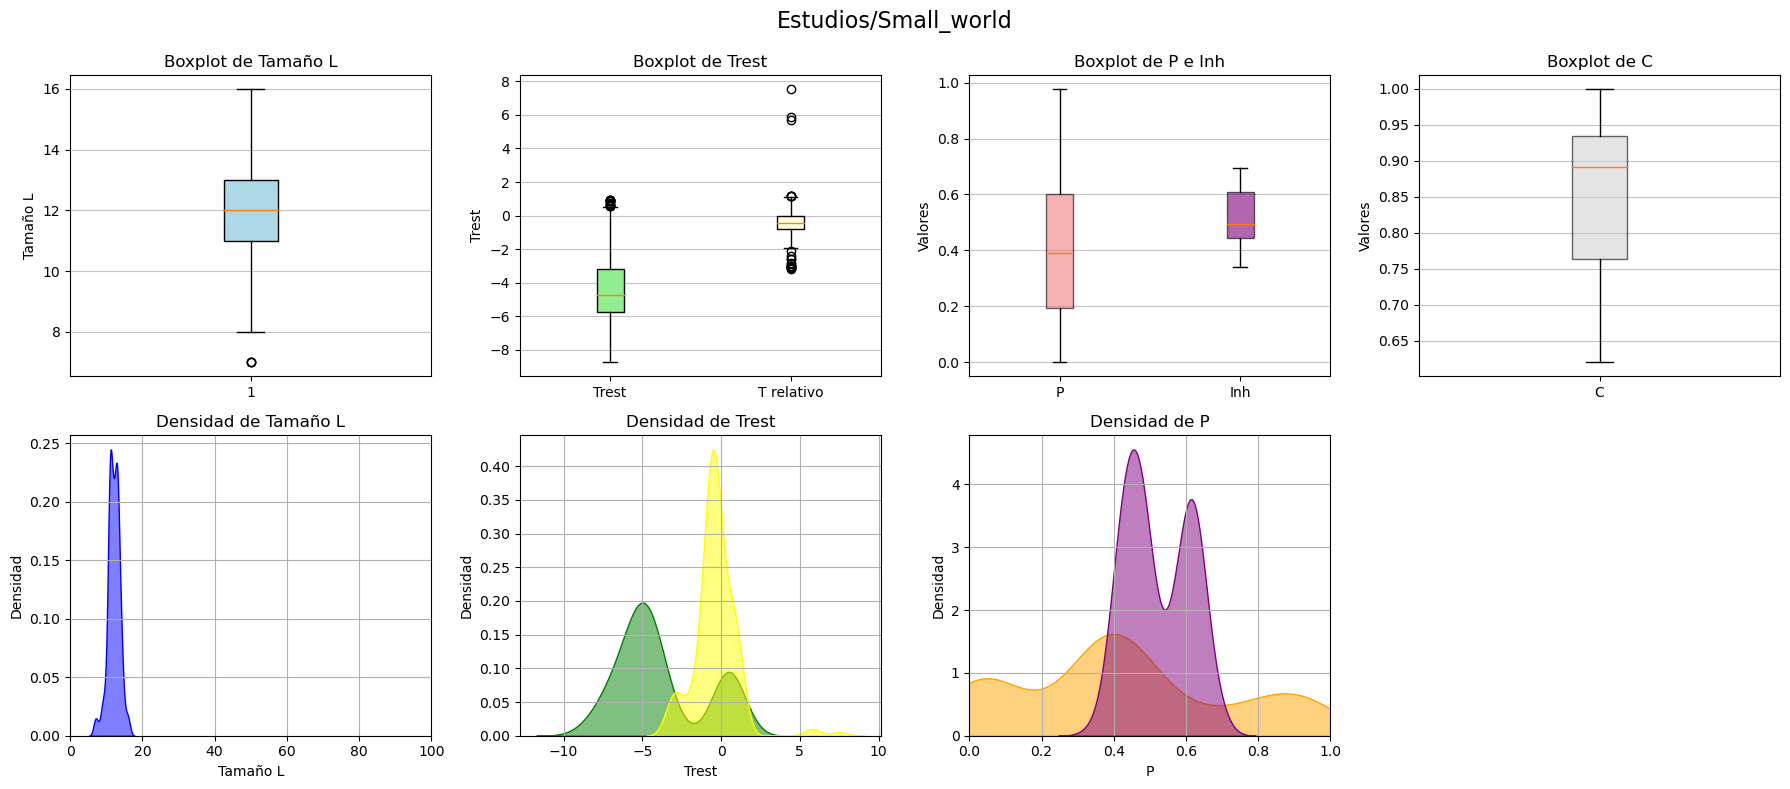

In [15]:
print(f"\nMedia del L: {np.mean(sizes)}")
print(f"Desviación estándar del L: {np.std(sizes)}")
print(f"Mediana del L: { np.median(sizes)}")
print(f"Primer cuartil (Q1) del L: {np.percentile(sizes, 25)}")
print(f"Tercer cuartil (Q3) del L: {np.percentile(sizes, 75)}")


print(f"\nMedia del Trest: {np.mean(trest_values)}")
print(f"Desviación estándar del Trest: {np.std(trest_values)}")
print(f"Mediana del Trest: {np.median(trest_values)}")
print(f"Primer cuartil (Q1) del Trest: {np.percentile(trest_values, 25)}")
print(f"Tercer cuartil (Q3) del Trest: {np.percentile(trest_values, 75)}")

print(f"\nMedia del Trela: {np.mean(trela_values)}")
print(f"Desviación estándar del Trela: {np.std(trela_values)}")
print(f"Mediana del Trela: {np.median(trela_values)}")
print(f"Primer cuartil (Q1) del Trela: {np.percentile(trela_values, 25)}")
print(f"Tercer cuartil (Q3) del Trela: {np.percentile(trela_values, 75)}")

print(f"\nMedia del P: {np.mean(P_values)}")
print(f"Desviación estándar del P: {np.std(P_values)}")
print(f"Mediana del P: { np.median(P_values)}")
print(f"Primer cuartil (Q1) del P: {np.percentile(P_values, 25)}")
print(f"Tercer cuartil (Q3) del P: {np.percentile(P_values, 75)}")

print(f"\nMedia del Inh: {np.mean(Inh_values)}")
print(f"Desviación estándar del Inh: {np.std(Inh_values)}")
print(f"Mediana del Inh: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del Inh: {np.percentile(Inh_values, 25)}")
print(f"Tercer cuartil (Q3) del Inh: {np.percentile(Inh_values, 75)}")

print(f"\nMedia del C hiper: {np.mean(Chiper)}")
print(f"Desviación estándar del C hiper: {np.std(Chiper)}")
print(f"Mediana del C hiper: { np.median(Inh_values)}")
print(f"Primer cuartil (Q1) del C hiper: {np.percentile(Chiper, 25)}")
print(f"Tercer cuartil (Q3) del C hiperh: {np.percentile(Chiper, 75)}")
plt.figure(figsize=(18, 8))

# Boxplot de Tamaño L
plt.subplot(2, 4, 1)
plt.boxplot(sizes, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Tamaño L')
plt.ylabel('Tamaño L')
plt.grid(axis='y', alpha=0.75)

# Boxplot de Trest
plt.subplot(2, 4, 2)
plt.boxplot(trest_values, patch_artist=True, boxprops=dict(facecolor='lightgreen'),labels=["Trest"])
plt.boxplot(trela_values, patch_artist=True, boxprops=dict(facecolor='lightyellow'),positions=[2],labels=['T relativo'])
plt.title('Boxplot de Trest')
plt.ylabel('Trest')
plt.grid(axis='y', alpha=0.75)

# Boxplot de P
plt.subplot(2, 4, 3)
plt.boxplot(P_values, patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.6), labels=['P'])  # Asignar etiqueta para P
plt.boxplot(Inh_values, patch_artist=True, boxprops=dict(facecolor='purple', alpha=0.6), positions=[2])  # Asignar etiqueta para Inh, en posición 2
plt.title('Boxplot de P e Inh')
plt.ylabel('Valores')
plt.xticks([1, 2], ['P', 'Inh'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 4, 4)
plt.boxplot(Chiper, patch_artist=True, boxprops=dict(facecolor='lightgrey', alpha=0.6), labels=['C'])  # Asignar etiqueta para P
plt.title('Boxplot de C')
plt.ylabel('Valores')
plt.xticks([1], ['C'])  # Asignar etiquetas a los ticks del eje x
plt.grid(axis='y', alpha=0.75)


plt.subplot(2, 4, 5)
sns.kdeplot(sizes, fill=True, color='blue', alpha=0.5)
plt.title('Densidad de Tamaño L')
plt.xlabel('Tamaño L')
plt.xlim(0,100)
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para Trest
plt.subplot(2, 4, 6)
sns.kdeplot(trest_values, fill=True, color='green', alpha=0.5)
sns.kdeplot(trela_values, fill=True, color='yellow', alpha=0.5)
plt.title('Densidad de Trest')
plt.xlabel('Trest')
plt.ylabel('Densidad')
plt.grid()

# Gráfico de densidad para P
plt.subplot(2, 4, 7)
sns.kdeplot(P_values, fill=True, color='orange', alpha=0.5)
sns.kdeplot(Inh_values, fill=True, color='purple', alpha=0.5)
plt.title('Densidad de P')
plt.xlabel('P')
plt.xlim(0,1)
plt.ylabel('Densidad')
plt.grid()

plt.suptitle(study_directory, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.99]) 
plt.show()


# Comparaciones 

In [8]:
import optuna
import optuna.visualization as vis
import matplotlib.pyplot as plt
# Directorio donde están almacenados los estudios
study_directory = "Estudios/Full/"  # Ajusta según sea necesario
study_name = "Chi30_zscore_L10"  # Cambia al nombre de tu estudio
# Cargar el estudio
study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_directory}{study_name}.db")
# Obtener el número de pruebas
num_trials = len(study.trials)

# Imprimir el número de pruebas
print(f"Número de pruebas en el estudio '{study_name}': {num_trials}")


KeyError: 'Record does not exist.'

In [17]:
# Gráfico de correlación entre los parámetros y los objetivos
vis.plot_param_importances(study)


[W 2024-11-06 12:51:35,171] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,172] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,172] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,172] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,173] Trial 15 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,173] Trial 17 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,173] Trial 18 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,173] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,174] Trial 22 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:35,174] Tri

In [18]:
# Gráfico de slice para explorar la relación entre los parámetros y los objetivos
%matplotlib inline
vis.plot_slice(study)


[W 2024-11-06 12:51:41,924] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,925] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,926] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,926] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,927] Trial 15 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,927] Trial 17 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,927] Trial 18 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,928] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,928] Trial 22 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:41,928] Tri

In [19]:
# Gráfico de coordenadas paralelas para visualizar múltiples objetivos
%matplotlib inline
vis.plot_parallel_coordinate(study)


[W 2024-11-06 12:51:42,294] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,295] Trial 6 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,295] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,296] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,296] Trial 15 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,297] Trial 17 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,297] Trial 18 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,297] Trial 21 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,297] Trial 22 is omitted in visualization because its objective value is inf or nan.
[W 2024-11-06 12:51:42,298] Tri